# Sentiment Tree

[link](https://nlp.stanford.edu/sentiment/)

## Recursive neural network

Ostatnim typem sieci, które poznamy są <b>Rekursywne sieci neuronowe</b> (<i>Recursive neural networks</i>). Pozwalają one na predykcję i generowanie nowych informacji na podstawie ustrukturyzowanych danych (np. wypowiedzi w języku naturalnym) albo obrazów.


Punktem wyjścia w ich przypadku jest <b>analiza składniowa</b> (<i>parsing</i>) - jedno z narzędzi lingwistycznych pozwalających badać strukturę gramatyczną i treść dowolnego ciągu znaków. Polega ona na badaniu:
- znaczenia słów
- reguł łączących je w całość

Jednym z najpowszechniej sposób reprezentowania języka w ramach analizy składniowej są <b>drzewa wyprowadzenia</b> (<i>parse trees</i>):

[![](https://upload.wikimedia.org/wikipedia/commons/6/6e/ParseTree.svg)](https://en.wikipedia.org/wiki/Parse_tree)

Sieci rekursywne wykorzystują właśnie drzewa wyprowadzenia do przetwarzania języka naturalnego (ale też obrazów i dowolnych innych ustrukturyzowanych danych). Każdy pojedynczy symbol (jedno słowo, jeden fragment rysunku, etc.) jest reprezentowany przez wektor wartości liczbowych $c_i$ długości $n$.

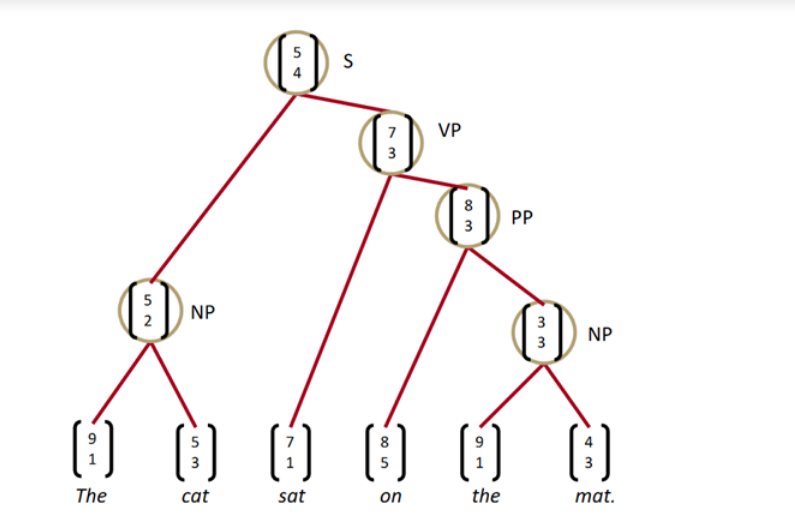

Każdy węzeł nadrzędny jest złożeniem dwóch węzłów $c_i$ i $c_j$ postaci: 

$p_{ij} = f(W [{c_i \atop c_j}] +b)$,

gdzie $f$ to funkcja aktywacji wprowadzająca nieliniowość (zazwyczaj tangens hiperboliczny), a $W$ to macierz wag $n \times 2n$, który jest taki sam dla każdej pary węzłów w sieci. Wartość $p_{ij}$ służy do wyznacznia jakości połączenia pomiędzy węzłami:

$p_{\eta} = f(W [{p_{ij} \atop p_{nm}}] +b)$,

Ostatecznie wyznaczamy wartość korzystając z warstwy specyficznej dla danego zadania:

$s_n = g(\theta^Tp_{\eta})$

gdzie $\theta$ to waga ostatniej warstwy a $p_{\eta}$ oszacowanie na korzeniu drzewa.

[![](https://upload.wikimedia.org/wikipedia/commons/6/60/Simple_recursive_neural_network.svg)](https://en.wikipedia.org/wiki/Recursive_neural_network)

Najczęściej występującą strukturą takiego drzewa jest <b>self-balancing binary search tree</b>,  czyli drzewa, które zachowują możliwie jak najmniejszą głębokość, zazwyczaj rzędu  $O(\log n)$.


Dzieki zastosowaniu takiego drzewa jesteśmy wstanie relatywnie szybko optymalizować jego strukturę (czas iterowania po wszystkich wierzchołkach jest rzędu $O(n)$, efektywność operacji na wierzchołkach, ich usuwanie, modyfikacja są rzędu co najwyżej $O(\log n)$).

Przy czym, gdy mamy taką strukturę danych w przypadku której jestesmy w stanie zaproponować odpowiednią formę drzewa, wtedy efektywniejsze będzie zastosowanie takiej specyficznej struktury

Optymalizując rekursywną sieć neuronową staramy się osiągnąć możliwie jak najwyższy wynik (<i>score</i>) na całym drzewie:

$$s(x,y) = \sum_{i \in ||N||} s_n(x_n,y_n)$$

gdzie $x$ to reprezentacja obiektu (wyrażenia) a $y$ drzewo parsowania.

Funkcja straty przyjmuje postać:

$$J = \sum_i (s(x_i,y_i) - \max_{y \in A(x_i)} (s(x_i,y) + \Delta(y,y_i)))$$

gdzie $A(x_i)$ to przestrzeń wszystkich dopuszczalnych drzew dla sentencji $x_i$, a $ \Delta(y,y_i)$ liczba wszystkich źle zaklasyfikowanych drzew.

## Embedding

Aby odpowiednio uczyć model rekursywny potrzebujemy odpowiedniej reprezentacji słów w postaci liczbowej. Naturalnie możemy zastosować wektory binarne, jednak takie kodowanie ma jedną zasadniczą wadę - wszystkie reprezentacje słów są jednakowo od siebie oddalone.

To co chcemy osiągnąć, to sytuacja w której słowa o podobnym znaczeniu (lub roli), będą osadzone blisko siebie:

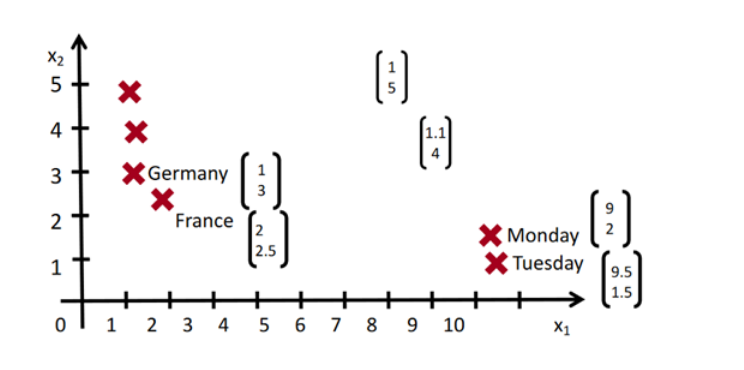

W tym celu możemy wykorzystać różne algorytmy <b>embeddingu</b> (<i>osadzania</i>) danych. Naturalnie możliwości jest wiele, zaczynając od prostych linowych algorytmów jak <i>PCA</i>, kończąc na bardziej złożonych metodach, takich jak autoencodery.

Problem osadzania danych dotyczy także innych typów danych relacyjnych, np. [grafów](https://arxiv.org/pdf/1709.07604.pdf).

Skupimy się teraz na specificznej klasie embedingów, która wykorzystuje sieci neuronowe do osadzania danych bazując na ich kontekście.

### word2vec

[<b>word2vec</b>](https://arxiv.org/pdf/1301.3781.pdf) to relatywnie prosty model. Składa się on z dwóch warstw - pierwsza z nich $V \in \mathbb{R}^{N \times d}$ jest warstwą liniową, która osadza słowo (reprezentowane jako $N$-elementowy wektor binarny) w $d$-wymiarowej przestrzeni liczb rzeczywstych. Druga warstwa $U \in \mathbb{R}^{d \times N}$ zwraca prawdopodobieństwo tego, że dany wektor zmiennych ukrytych reprezentuje $i$-te słowo dla $i \in [1,2,\dots,N]$:
 
[![](http://mccormickml.com/assets/word2vec/skip_gram_net_arch.png)](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/)

Do procesu uczenia takiego modelu możemy wykorzystać dwie architektury:

>* CBOW (Continuous Bag-Of-Words) 
>* Skip-gram

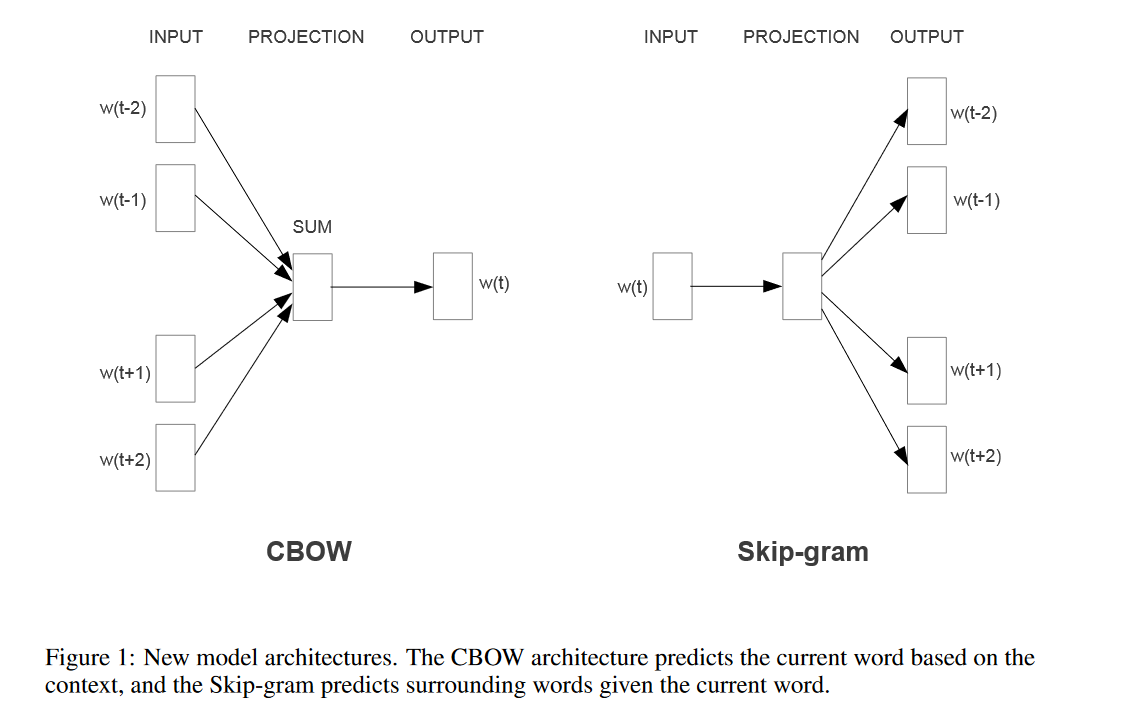

Ze względu na znacznie szybszy proces uczenia i lepsze wyniki skupimy się na modelu <b>skip-gram</b>.

Funkcją kosztu takiego modelu jest równa:

$$J(\theta) = - \log P(\{w_{c-\ell},\dots,w_{c-1},w_{c+1},\dots,w_{c+\ell}\}|w_c; \theta)$$

Naiwnie zakładając, że słowa kontekstowe są warunkowo niezależne, funkcja kosztu przyjmuję postać:

$$J(\theta) = - \log \prod_{-\ell \leq j \geq \ell, j \neq c} P(w_{c+j}|w_c;\theta)$$

Prawdopodobieństwo $P(w_{c+j}|w_c;\theta)$ jesteśmy w stanie łatwo przedstawić jako:

$$P(w_{c+j}|w_c;\theta) = \dfrac{\exp (u_{c+j}^\top v_c)}{\sum_{w}\exp (u_w^\top v_c)}$$

gdzie $v_i$ to wiersz macierzy $V$ odpowiadający słowu $i$, a $u_j$ to kolumna macierzy $U$ odpowiadająca słowu $j$. 

Problemem z bazową formą funkcji kosztu jest to, że wewnątrz funkcji softmax musimy sumować prawdopodobieństwa dla wszystkich słów w zbiorze. Ta liczba może być wysoka, powodując nieefektywność obliczeniową takiego podejścia. Funkcje kosztu możemy w łatwy sposób zmodyfikować tak, aby przybliżala prawdopodobieństwa za pomocą metody Monte Carlo. Tak zmodyfikowana funkcja kosztu nazywa się <b>Negative Sampling Loss</b>:

$$
- \large \log{\sigma\left(u_{c+j}\hspace{0.001em}^\top v_{c}\right)} -
\sum_i^N \mathbb{E}_{w_i \sim P_n(w)}\log{\sigma\left(-u_{w_N}\hspace{0.001em}^\top v_{c}\right)}
$$

gdzie $w_N$ to słowa wygenerowane z rozkładu $w_N \sim P_n(w)$, które nie należą do ona kontekstowego słowa $w_c$, a $N \leq 2\ell$. 

Przejdźmy do implementacji modelu:

In [1]:
using Random
using Base.Iterators: repeated, partition
import StatsBase.sample, StatsBase.Weights
using Flux
using Flux: onehot,onecold, onehotbatch
using Flux: crossentropy, throttle, params
using Zygote
using BSON, JLD2, Statistics
using CUDA

In [2]:
use_cuda = true

true

In [3]:
 if use_cuda && CUDA.functional()
    device = gpu
    @info "Training on GPU"
else
    device = cpu
    @info "Training on CPU"
end

[ Info: Training on GPU


Zacznijmy od wczytania i przygotowania danych, są one dostepne [tutaj](https://nlp.stanford.edu/sentiment/trainDevTestTrees_PTB.zip)

In [4]:
filedir = raw"trees"

"trees"

Do pracy na drzewach wykorzystamy bibliotekę [AbstractTrees](https://github.com/JuliaCollections/AbstractTrees.jl):

In [5]:
using AbstractTrees

In [6]:
mutable struct SentimentTree
    label::Int
    phrase::Union{Nothing,String}
    children::Vector{SentimentTree}
end

AbstractTrees.children(tree::SentimentTree) = tree.children;
isleaf(tree::SentimentTree) = isempty(tree.children) ? true : false;

Funkcja do parsowania drzew:

In [7]:
function parse_tree(str)
    str = replace(str, r"\(\d [^\w\)]{1,20000}\)" => "")
    str = replace(str, r"\(\d  \)" => "")
    leaves = [mtch.match for mtch in eachmatch(r"\(\d [^\(\)]{1,20000}\)", str)]
    labels = [parse(Int,split(replace(leaf,'(' => ' ', ')' => ' '))[1]) for leaf in leaves]
    phrases = [string(split(replace(leaf,'(' => ' ', ')' => ' '))[2]) for leaf in leaves]
    tree = [SentimentTree(labels[i], lowercase(phrases[i]), []) for i = 1:length(leaves)];
    for (i,leaf) in enumerate(leaves)
        leaf_range = findfirst(leaf, str)
        str = str[1:leaf_range.start - 1] * "leaf$i" * str[leaf_range.stop+1:end]
    end
    while length(leaves) > 1
        new_tree = []
        leaves = [mtch.match for mtch in eachmatch(r"\(\d [^\(\)]{1,20000}\)|leaf\d{1,9}", str)]
         for (i,leaf) in enumerate(leaves)
            indxs = [parse(Int,mtch.match) for mtch in eachmatch(r"\d{1,9}", leaf)]
            if length(indxs) == 3 
                push!(new_tree, SentimentTree(indxs[1], nothing, [tree[indxs[2]], tree[indxs[3]]]))
            elseif length(indxs) == 2
                new_leaf = tree[indxs[2]]
                new_leaf.label = indxs[1]
                push!(new_tree, new_leaf)
            else 
                push!(new_tree, tree[indxs[1]])
            end
            leaf_range = findfirst(leaf, str)
            str = str[1:leaf_range.start - 1] * "leaf$i" * str[leaf_range.stop+1:end]
        end
        tree = deepcopy(new_tree)
    end
    return tree[1]
end


parse_tree (generic function with 1 method)

In [8]:
train_trees = open(filedir * raw"\\train.txt") do f
           parse_tree.(readlines(f)) 
end;

In [9]:
# All tokens in the training set.
tokens = map(x->x.phrase, Leaves(train_trees));
#unique tokens:
alphabet = unique(tokens);

In [10]:
#count occurences of each word:
freqs = Dict{String,Int}()
for t in tokens
  freqs[t] = get(freqs, t, 0) + 1
end

# Replace singleton tokens with an "unknown" marker.
# This roughly cuts our "alphabet" of tokens in half.
for tree in train_trees
    map(t -> get(freqs, t.phrase, 0) == 1 ? t.phrase = "UNK" : t.phrase = t.phrase, Leaves(tree))
end

#Repeat:
# All tokens in the training set.
tokens = map(x->x.phrase, Leaves(train_trees));
#unique tokens:
alphabet = unique(tokens);

#count occurences of each word:
freqs = Dict{String,Int}()
for t in tokens
  freqs[t] = get(freqs, t, 0) + 1
end

#vector of senteces - for embedding training:
sentences = [[leaf.phrase for leaf in Leaves(tree)] for tree in train_trees];

Analogicznie, zbiór testowy:

In [11]:
test_trees = open(filedir * raw"\\test.txt") do f
           parse_tree.(readlines(f)) 
end;

for tree in test_trees
    map(t -> get(freqs, t.phrase, 0) == 1 || t.phrase ∉ alphabet ? t.phrase = "UNK" : t.phrase = t.phrase, Leaves(tree))
end


## word2vec

Teraz możemy odpowiednio przygotować dane do uczenia embeddingu.

W wielu przypadkach możemy zacząć od <b>subsamplingu</b> danych. Naszym celem jest usunięcie przedimków, zaimków, łączników, takich jak "the", "of", and "for". Takie słowa nie są przydatne w procesie uczenia, jednynie zaszumiają dane i sztucznie powiększają zbiór danych. 
* Każde słowo $w_i$ jest usuwane ze zbioru z prawdopodobieństwem: 
$$ P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}} $$

gdzie  $t$ to niewielki próg odcięcia (np. 1e-5) a $f(w_i) = \dfrac{count(w_i)}{\sum_{w_j} count(w_j)}$ to częstotliwość występowania słowa $w_i$.

In [12]:
train_alphabet = [word for word in alphabet if rand() < (1  - sqrt(1e-5/(freqs[word]/length(tokens))))];

Teraz sparsujemy zdania:

In [13]:
function parse_sentences!(sentences, K, alphabet)
    context_words = Dict(token => [] for token in alphabet)
    for sentence in sentences
        for (i, word) in enumerate(sentence)
            word ∉ alphabet && continue
            #word = onehot(word, alphabet)
            for j = i-K:i+K
                (j < 1 || j > length(sentence) || i == j) && continue
                #context_word = onehot(sentence[j], alphabet)
                context_word = sentence[j]
                push!(context_words[word], context_word)
                unique!(context_words[word])
            end
        end
    end
    map(token -> isempty(context_words[token]) && delete!(context_words, token), alphabet)
    filter!(token -> haskey(context_words, token) == true, alphabet)
    return  context_words
end


parse_sentences! (generic function with 1 method)

Wielkość okna kontekstowego (<i>context windows</i>):

In [14]:
#window = 2 
window = 5;

Wielkość okna kontekstowego jest jednym z kluczowych parametrów podczas uczenia embeddingu. Gdy jest ono krótkie (zazwyczaj przyjmuje się równe 2) kluczowym elementem, którego uczy się embedding jest rola słowa w zdaniu. Natomiast długie okno (5 lub więcej) wychwytuję podobieństwo znaczeń słów (np. nazwy krajów będą blisko siebie, a dalej od marek samochodów). Więcej informacj [tutaj](https://levyomer.files.wordpress.com/2014/04/dependency-based-word-embeddings-acl-2014.pdf).

In [15]:
context_words = parse_sentences!(sentences, window, alphabet);

Zdefiniujemy teraz sampler, który wykorzystamy do generowania szumu potrzebnego do wyznaczenia funkcji straty. Każda fałszywa obserwacja będzie losowana z odpowiedniego rozkładu: $w_N \sim P_n(w)$.  Jako $P_n(w)$ wykorzystamy rozkład unigram (<i>unigram distribution</i>) $U(w_i) = \dfrac{count (w_i)}{\sum_{w_j} count (w_j)}$. W szczególności będzie on miał postać $U(w)^{\tau}$, gdzie $\tau$ to czynnik wygładzający, zazwyczaj równy $3/4$.

In [16]:
#weights for the unigram sampler
unigram_sampler(alphabet, freqs, τ = 0.75) =  (sum_probs = sum(values(freqs).^τ); [freqs[token].^τ / sum_probs 
    for token in alphabet])

token_weights = Weights(unigram_sampler(alphabet, freqs));

Teraz możemy zdefiniować model:

In [17]:
latent_dim = 300

300

In [18]:
input_embedding = Dense(length(alphabet), latent_dim) |> device
output_embedding = Dense(length(alphabet), latent_dim) |> device

Dense(8197 => 300)  # 2_459_400 parameters

Funkcję generującą batch danych do uczenia sieci:

In [87]:
function gen_batch(wordlist, ℓ = 1, K = 2*window)
    data = []
    for word in wordlist
        for context_word_sample in rand(context_words[word], ℓ)
            neg_samples = Vector{Int}(undef,K)
            for i = 1:K
                neg_samples[i] = sample(1:length(alphabet), token_weights)
                while alphabet[neg_samples[i]] ∈ context_words[word]
                    neg_samples[i] = sample(1:length(alphabet), token_weights)
                end
            end
            #neg_samples_decode = decode.weight[neg_samples,:]
            push!(data, (onehot(word, alphabet), onehot(context_word_sample, alphabet), 
                    onehotbatch(alphabet[neg_samples], alphabet)))
        end
    end
    data  
end

gen_batch (generic function with 2 methods)

Funkcję kosztu:

In [20]:
function negative_sampling_loss(word, context_word, neg_samples) 
     l_context = -log(σ(transpose(output_embedding(context_word)) * input_embedding(word)))  
     l_negative = - sum(log.(σ.(transpose(-output_embedding(neg_samples))* input_embedding(word))))
    return l_context + l_negative
end

negative_sampling_loss (generic function with 1 method)

In [21]:
batch_size = 64
neg_sampling = 2*window
epochs = 100
opt = ADAM(0.003)

Adam(0.003, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}())

Podzielmy zbiór zdanych na batche:

In [91]:
w2v_data =  Flux.DataLoader(alphabet, batchsize=batch_size, shuffle=true);

i zacznijmy proces uczenia:

In [23]:
@info("Beginning training loop...")
loss = Inf
last_improvement = 0
for epoch = 1:epochs
    @info "Epoch $epoch"
    for word_batch in w2v_data
        data = gen_batch(word_batch)
        ps = params(input_embedding, output_embedding)
        _, back = Zygote.pullback(ps) do
            losses = [negative_sampling_loss(dt[1], dt[2], dt[3]) for dt in data]
            sum(losses)/length(losses)
        end
        grads = back(1f0)
        Flux.Optimise.update!(opt, ps, grads)
       
    end
    new_loss = begin
        losses = [negative_sampling_loss(dt[1], dt[2], dt[3]) for dt in gen_batch(rand(collect(w2v_data)))]
        sum(losses)/length(losses)
    end
    if new_loss < loss
            loss = new_loss
            @info "new best embedding!"
            @info("loss = $loss")
            model_params = cpu.(params(input_embedding, output_embedding))
            BSON.@save "word2vec.bson" model_params 
            jldsave("word2vec.jld2"; input_embedding = cpu.(params(input_embedding)), 
                                    output_embedding = cpu.(params(output_embedding)))
        last_improvement = epoch
    end
    if epoch - last_improvement ≥ 15
        @warn(" -> We're calling this converged.")
        break
    end
end

[ Info: Beginning training loop...
[ Info: Epoch 1
[ Info: new best embedding!
[ Info: loss = 3.2570128
[ Info: Epoch 2
[ Info: Epoch 3
[ Info: Epoch 4
[ Info: Epoch 5
[ Info: new best embedding!
[ Info: loss = 3.0855348
[ Info: Epoch 6
[ Info: Epoch 7
[ Info: new best embedding!
[ Info: loss = 3.0223722
[ Info: Epoch 8
[ Info: Epoch 9
[ Info: Epoch 10
[ Info: Epoch 11
[ Info: Epoch 12
[ Info: Epoch 13
[ Info: new best embedding!
[ Info: loss = 2.9891899
[ Info: Epoch 14
[ Info: Epoch 15
[ Info: Epoch 16
[ Info: Epoch 17
[ Info: Epoch 18
[ Info: new best embedding!
[ Info: loss = 2.9641838
[ Info: Epoch 19
[ Info: Epoch 20
[ Info: new best embedding!
[ Info: loss = 2.9528735
[ Info: Epoch 21
[ Info: new best embedding!
[ Info: loss = 2.753295
[ Info: Epoch 22
[ Info: Epoch 23
[ Info: new best embedding!
[ Info: loss = 2.3590724
[ Info: Epoch 24
[ Info: Epoch 25
[ Info: Epoch 26
[ Info: Epoch 27
[ Info: Epoch 28
[ Info: Epoch 29
[ Info: Epoch 30
[ Info: Epoch 31
[ Info: Epoch 32
[ Info:

[ Info: Epoch 100


Wczytajmy i przetestujmy najlepszy model:

In [24]:
input_embedding = Dense(length(alphabet), latent_dim) |> device
output_embedding = Dense(length(alphabet), latent_dim) |> device

model_params = JLD2.load("word2vec.jld2")

Flux.loadparams!(input_embedding, device.(model_params["input_embedding"]))
Flux.loadparams!(output_embedding, device.(model_params["output_embedding"]))

ls = begin
    losses = [negative_sampling_loss(dt[1], dt[2], dt[3]) for dt in gen_batch(rand(collect(w2v_data)))]
    sum(losses)/length(losses)
end

1.2736946f0

Sprawdźmy czy faktycznie słowa o podobnym znaczeniu (lub roli) są osadzane w swoim sąsiedztwie. Jako metrykę wykorzystamy cosinus pomiędzy dwoma wektorami:

$$\cos(\theta) = \frac{\vec{a} \cdot \vec{b}}{|\vec{a}||\vec{b}|}$$

In [25]:
cos_sim(x,y) = (x'*y)/(sqrt(x'x) * sqrt(y'*y)) 

cos_sim (generic function with 1 method)

In [34]:
amazing = input_embedding(onehot("amazing", alphabet))
awesome = input_embedding(onehot("awesome", alphabet));
bad = input_embedding(onehot("bad", alphabet));
paris = input_embedding(onehot("paris", alphabet));
london = input_embedding(onehot("london", alphabet));
creep = input_embedding(onehot("seagal", alphabet));
arnie = input_embedding(onehot("schwarzenegger", alphabet));

In [38]:
@show cos_sim(amazing,awesome) 
@show cos_sim(amazing,bad) 
@show cos_sim(awesome,bad) 
@show cos_sim(paris,london) 
@show cos_sim(creep,arnie) 
@show cos_sim(arnie,london);

cos_sim(amazing, awesome) = 0.9785792f0
cos_sim(amazing, bad) = 0.32382345f0
cos_sim(awesome, bad) = 0.33500934f0
cos_sim(paris, london) = 0.97837573f0
cos_sim(creep, arnie) = 0.34679946f0
cos_sim(arnie, london) = 0.3509608f0


## Sentiment Tree

Wróćmy do budowy podstawowego modelu. Zdefiniujmy warstwy: 

In [81]:
latent_dim = 300
epochs = 200
batch_size = 16

#losowy embedding, 
#można go wykorzystać do sprawdzenia jaką rolę w przewidywaniu wydźwięku odgrywa struktura gramatyczna drzewa:
#embedding = randn(N, length(alphabet)) |> device;
embedding = deepcopy(input_embedding.weight) |> device;
W = Dense(2latent_dim, latent_dim, tanh) |> device 
sentiment = Chain(Dense(latent_dim, 5), softmax) |> device

Chain(
  Dense(300 => 5),                      # 1_505 parameters
  NNlib.softmax,
) 

Podzielmy zbiór:

In [82]:
rnn_data = Flux.DataLoader(train_trees, batchsize=batch_size, shuffle=true);

Zdefiniujmy funkcję propagującą informację w drzewie:  

In [83]:
function forward(tree)
  if isleaf(tree)
    token =  onehot(tree.phrase, alphabet)
    label = onehot(tree.label, 0:4)
    phrase = embedding * token
    phrase, crossentropy(sentiment(phrase), label)
  else
    label = onehot(tree.label, 0:4)
    c1, l1 = forward(tree.children[1])
    c2, l2 = forward(tree.children[2])
    phrase = W(vcat(c1, c2))
    phrase, l1 + l2 + crossentropy(sentiment(phrase), label)
  end
end

#RNNloss(tree) = forward(tree)[2]

RNNloss(trees) = sum(forward(tree)[2] for tree in trees)/length(trees)

predict(tree) = sentiment(forward(tree)[1])

accuracy(trees) = mean(onecold.(predict.(trees)) .== map(x -> x.label,trees))

accuracy (generic function with 1 method)

In [84]:
accuracy(test_trees)

0.1832579185520362

Zdefiniujmy parametry modelu i zacznijmy proces uczenia:

In [85]:
opt = ADAM(0.001)
ps = params(embedding, W, sentiment)
evalcb = () -> @show accuracy(test)

#91 (generic function with 1 method)

In [86]:
@info("Beginning training loop...")
best_acc = 0.0
last_improvement = 0
for epoch = 1:epochs
    @info "Epoch: $epoch"
    global best_acc, last_improvement
    Flux.train!(RNNloss, ps, rnn_data, opt)
    acc = accuracy(test_trees)
    if acc >= best_acc
        @info "New best result: $acc"
        model_params = cpu.(params(embedding, W, sentiment))
        BSON.@save "sentiment.bson" model_params
        jldsave("sentiment.jld2"; embedding = cpu.(params(embedding)), W = cpu.(params(W)), 
                                    sentiment = cpu.(params(sentiment)))
        best_acc = acc
        last_improvement = epoch
    end
    if epoch - last_improvement >= 10
        @warn(" -> We're calling this converged.")
        break
    end
end

[ Info: Beginning training loop...
[ Info: Epoch: 1
[ Info: New best result: 0.251131221719457
[ Info: Epoch: 2
[ Info: New best result: 0.25429864253393664
[ Info: Epoch: 3
[ Info: Epoch: 4
[ Info: Epoch: 5
[ Info: Epoch: 6
[ Info: Epoch: 7
[ Info: Epoch: 8
[ Info: Epoch: 9
[ Info: Epoch: 10
[ Info: Epoch: 11
[ Info: Epoch: 12
┌ Warning:  -> We're calling this converged.
└ @ Main In[86]:19


## Dodatkowa praca domowa

1. Popraw prezentowany model tak aby otrzymać możliwie jak najwyższą trafność predykcji na korzeniu drzewa <b>(15 punktów)</b>.